## Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from moviepy.editor import *
from IPython.display import HTML


## Helper Functions

Below are some helper functions.

In [2]:
import math

# A function to focus on a particular color (yellow to white, in this case)
def color_focus(image):
    # the range of shades of yellow to detect, in HSV
    yellow_min_hsv = (20, 90, 160)
    yellow_max_hsv = (23, 255, 255)
    # the range of shades of white to detect, in HSV
    white_min_hsv = (0, 0, 200)
    white_max_hsv = (179, 25, 255)
    
    # convert the image from rgb to hsv, for easy manipulation
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # a mask to filter only the tones of yellow that are between those specified
    yellow_mask = cv2.inRange(hsv_image, yellow_min_hsv, yellow_max_hsv)
    # a mask to filter only the tones of white that are between those specified
    white_mask = cv2.inRange(hsv_image, white_min_hsv, white_max_hsv)
    # combining the masks so only whites and yellows are kept in the image
    full_mask = yellow_mask | white_mask
    new_image = cv2.bitwise_and(image, image, mask=full_mask)
    
    return new_image


def grayscale(img):
    #Applies the Grayscale transform
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def gaussian_blur(img, kernel_size):
    #Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def canny(img, low_threshold, high_threshold):
    #Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)


def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on the image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def detect_outliers(data, threshold=3):
    '''
    Returns the mask of where the outliers are.
    @param data: array containing the dataset
    @param threshold: number determining how many standard deviations away from the mean the outliers must be
    @return an array with a mask of where all elements outside -threshold*std to +threshold*std
    '''
    mean = np.mean(data)
    std = np.std(data)
    
    # anything outside [-threshold*std, +threshold*std] is an outlier
    outlier_mask = abs((data - mean)/std) > threshold
    
    return outlier_mask


def extend_data(data, weights):
    """
    Each column in data will be repeated according to its weight
    @param data: a NxM array
    @param weights: an 1xM array where each element determines how many times each column must be repeated
    """        
    # making sure the weights are integers, as data can only be repeated an integer number of times
    weights = np.int32(weights)
    
    extended_data = np.zeros((data.shape[0], weights.sum()))
    
    i = 0  # iterates over the extended_data array
    for j in range(len(weights)):
        # repeating the j-th column (data[:, j]) weights[j] times and placing it in the section extended_data[:, i:i + weights[j]]
        extended_data[:, i:i + weights[j]] = np.repeat([data[:, j]], weights[j], axis=0).T
        i += weights[j]
    
    return extended_data
    
    
def filter_lines(lines, threshold=3, summary_required=False):
    """
    Returns either a set of lines with reasonable slope and vertical offsets (if summary_required is False)
    or the mean slope and mean vertical offset of both the right and left lane lines (if summary_required is True).
    
    @param lines: the set of lines obtained from the Hough transform
    @param threshold: passedd to the detect_outliers() function, in order to remove the outliers
    @param summary_required: determines what is returned
    """
    # an array containing the slopes, line lengths and vertical offsets, one row for each parameter, one column for each line
    lines_data = np.zeros((3, len(lines)))

    # References to the corresponding parameters in the array, for readability
    slopes, y_offsets, lengths = lines_data

    i = 0  # to keep track of the iterations

    for line in lines:
        for x1,y1,x2,y2 in line:
            # being careful with vertical lines
            try:
                slopes[i] = (y2-y1)/(x2-x1)
            except:
                # they won't be used, anyway
                slopes[i] = np.inf
                
            # calculate the vertical offset (y at x=0) of each line
            y_offsets[i] = (y1 - slopes[i] * x1)
               
            # longer lines have more influence on the mean of the slope of the lane lines
            lengths[i] = np.ceil(np.sqrt((x2-x1)**2 + (y2-y1)**2))

        i += 1
        
    min_angle = 25  # mininum acceptable angle in degrees
    max_angle = 80  # maximum acceptable angle in degrees
    
    # a mask indicating where the lines with acceptable slopes are or not
    reasonable_angles_mask = (abs(np.degrees(np.arctan(slopes))) > min_angle) & (abs(np.degrees(np.arctan(slopes))) < max_angle)
    
    # lines whose slope is within -threshold_angle to +threshold_angle deg will be removed, as they are almost horizontal
    right_mask = (slopes > 0) & reasonable_angles_mask
    right_lines = lines[right_mask]
    # separating the rows for readability
    r_slopes, r_y_offsets, r_lengths = right_lines_data = lines_data[:, right_mask]
    
    # lines with a negative slope are on the left-hand side
    left_mask = (slopes < 0) & reasonable_angles_mask
    left_lines = lines[left_mask]
    l_slopes, l_y_offsets, l_lengths = left_lines_data = lines_data[:, left_mask]
    
    # if only the summary is required (final step in drawing lanes)
    if summary_required:
        # extending the following arrays to facilitate calcualtion of mean and removing outliers
        # leaving the last row of the lines_data arrays, as those do not need be extended
        r_slopes, r_y_offsets = r_full_data = extend_data(right_lines_data[:2], r_lengths)
        l_slopes, l_y_offsets = l_full_data = extend_data(left_lines_data[:2], l_lengths)

        # removing the lines with abnormal slopes and vertical offsets form the lines to be plotted
        r_slopes, r_y_offsets = r_full_data[:, ~(detect_outliers(r_slopes, threshold) & detect_outliers(r_y_offsets, threshold))]
        l_slopes, l_y_offsets = l_full_data[:, ~(detect_outliers(l_slopes, threshold) & detect_outliers(l_y_offsets, threshold))]
        
        return r_slopes.mean(), r_y_offsets.mean(), l_slopes.mean(), l_y_offsets.mean()
    
    # if only the filtered lines are required
    # concatenate the two sets of lines for drawing purposes
    return np.concatenate((right_lines, left_lines))

    
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    #This function draws `lines` with `color` and `thickness` on the same image passed as argument.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def draw_lanes(img, vertices, lines, color=[255, 0, 0], thickness=5, filter_threshold=3):
    # getting the average slopes and vertical offsets from the lines passed as argument
    r_slope, r_y_offset, l_slope, l_y_offset = filter_lines(lines, threshold=filter_threshold, summary_required=True)
    
    # Now that there are two lines, each with its own slope and vertical offset, they need to be drawn on the passed image
    # These lines will be drawn on the whole image, from the bottom to the top, and then a mask will ensure only the region
    # within the vertices is shown
    y1 = 0  # the top of the image
    y2 = img.shape[0]  # the bottom part of the image
    
    r_x1 = int((y1 - r_y_offset)/r_slope)
    r_x2 = int((y2 - r_y_offset)/r_slope)

    l_x1 = int((y1 - l_y_offset)/l_slope)
    l_x2 = int((y2 - l_y_offset)/l_slope) 

    # drawing the lines from top to bottom on a 3 channel black image
    black_image = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)  # a black image with 3 color channels
    cv2.line(black_image, (r_x1, y1), (r_x2, y2), color, thickness)
    cv2.line(black_image, (l_x1, y1), (l_x2, y2), color, thickness)
    
    # applying the mask, so the lines are only in the region of interest
    black_image = region_of_interest(black_image, vertices)

    return black_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img, lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

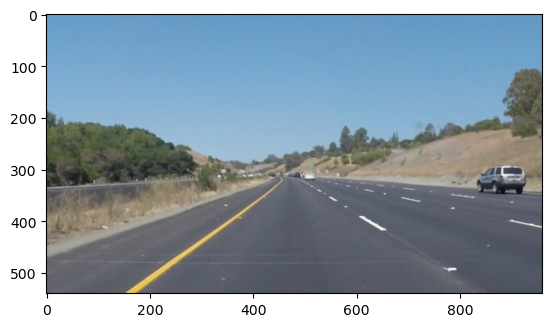

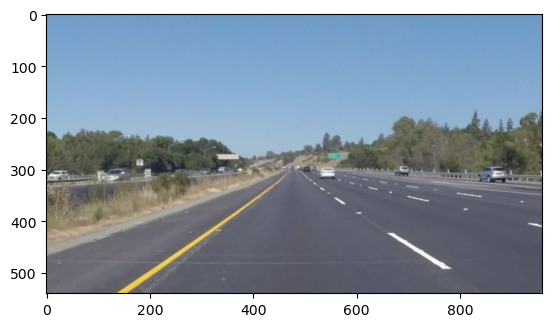

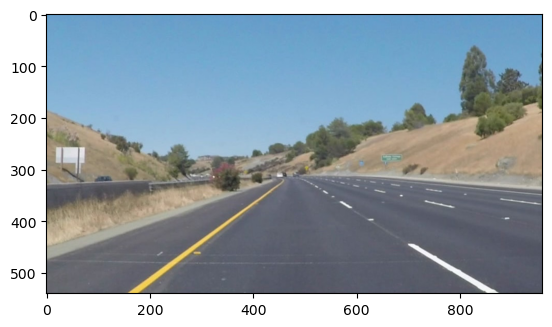

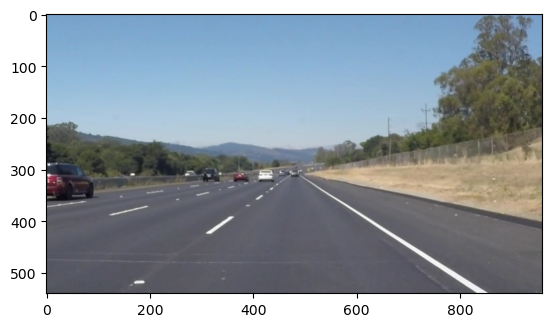

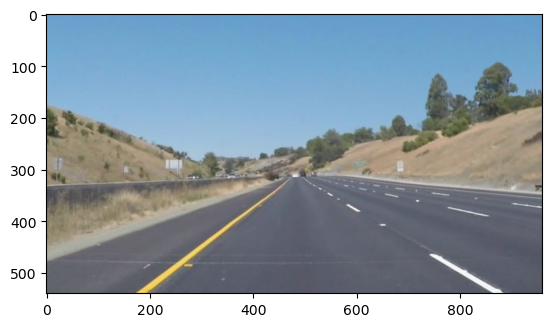

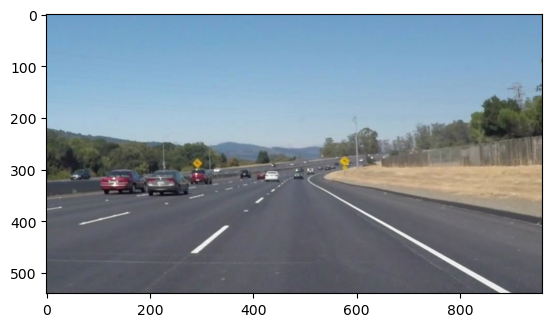

In [3]:
import os
raw_images = []

image_names = os.listdir("test_images/")
for image_name in image_names:
    raw_images.append(mpimg.imread("test_images/"+image_name))

##adding some frames of the test videos to the raw images
# clip1 = np.array(list(VideoFileClip("test_videos/solidYellowLeft.mp4").iter_frames()))
# raw_images.extend([clip1[180], clip1[675]])

# clip3 = np.array(list(VideoFileClip("test_videos/challenge.mp4").iter_frames()))
# raw_images.extend([clip3[97], clip3[155]])

for image in raw_images:
    # plotting the test images
    plt.figure()
    plt.imshow(image)
    
# getting the size of the image or video frame
(y_size, x_size, _) = raw_images[0].shape

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

True

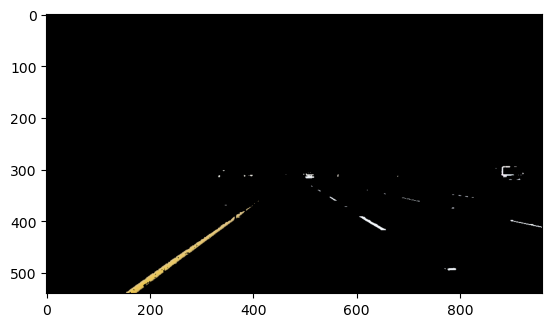

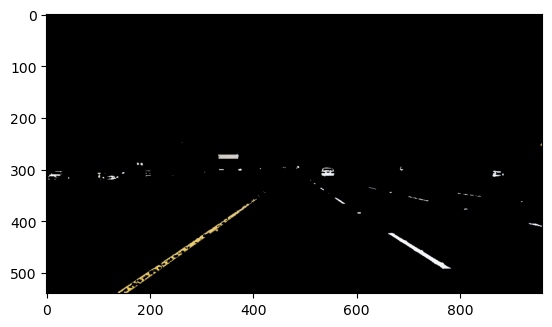

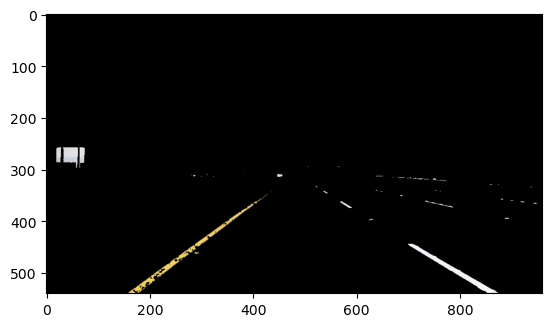

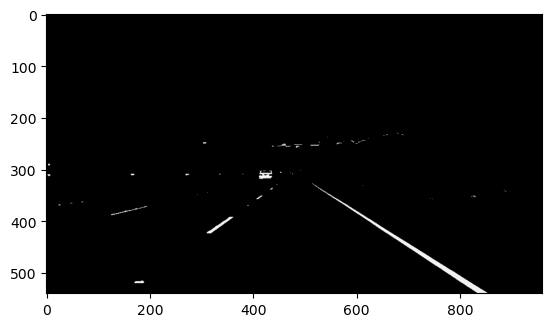

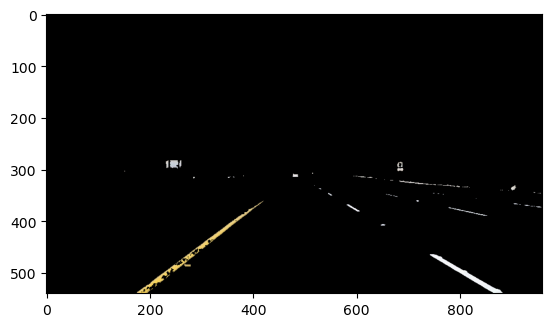

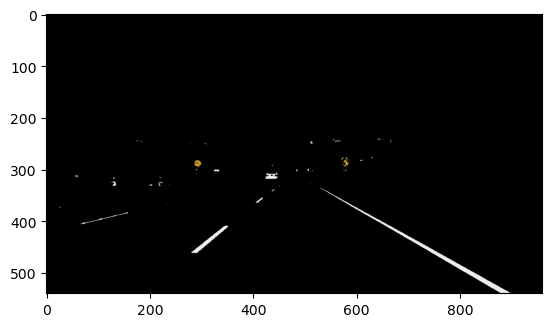

In [4]:
color_focused = []

for i in range(len(raw_images)):
    new_image = color_focus(raw_images[i])
    color_focused.append(new_image)
    plt.figure()
    plt.imshow(new_image)

# Saving one of the images for the report
cv2.imwrite("test_images_output/image"+"3"+"color_focused.png", cv2.cvtColor(color_focused[3], cv2.COLOR_RGB2BGR))

True

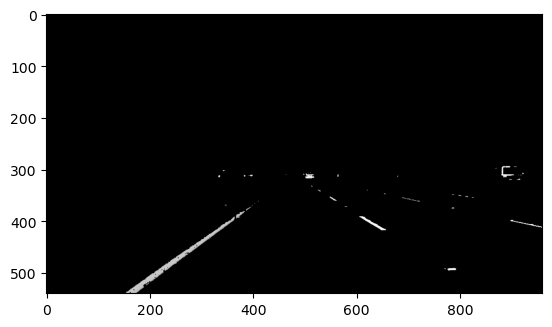

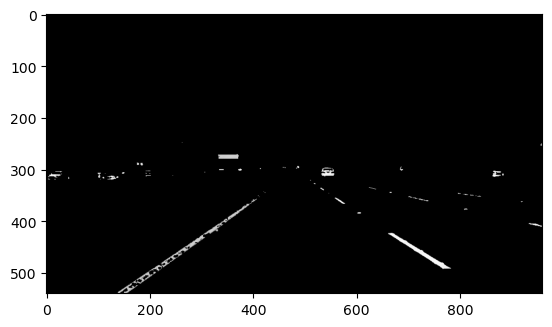

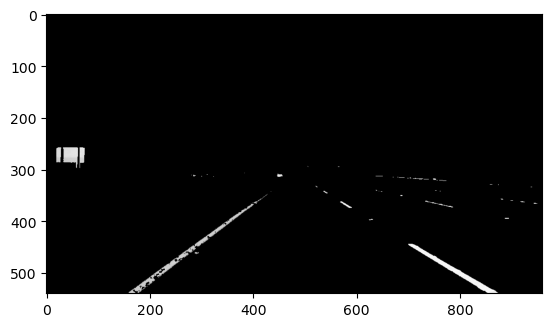

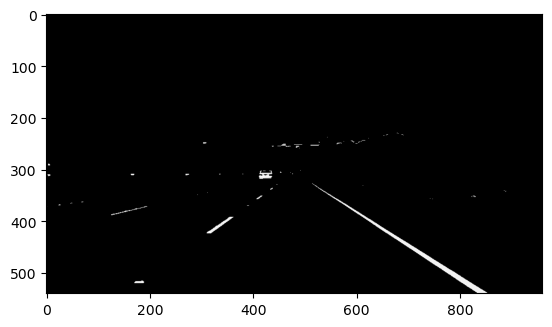

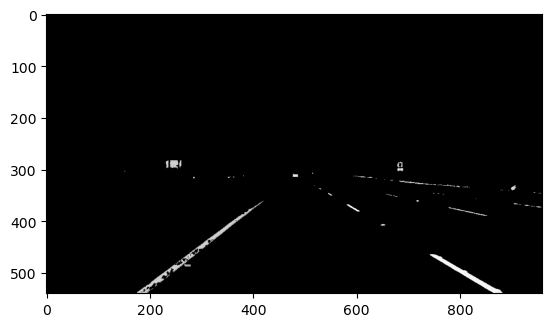

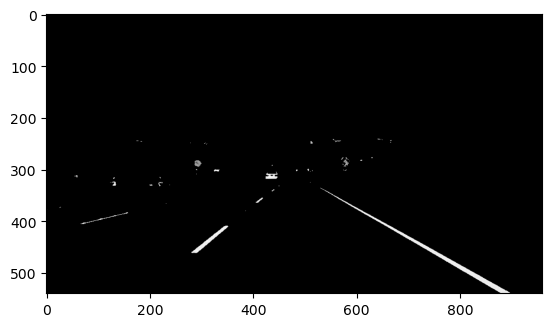

In [5]:
grayed = []  # a list that will contain the grayed out images
# converting the images above to grayscale
for image in color_focused:
    grayed_image = grayscale(image)
    grayed.append(grayed_image)
    plt.figure()
    plt.imshow(grayed_image, cmap='gray')
    
# Saving one of the images for the report
cv2.imwrite("test_images_output/image"+"3"+"grayed.png", cv2.cvtColor(grayed[3], cv2.COLOR_RGB2BGR))

True

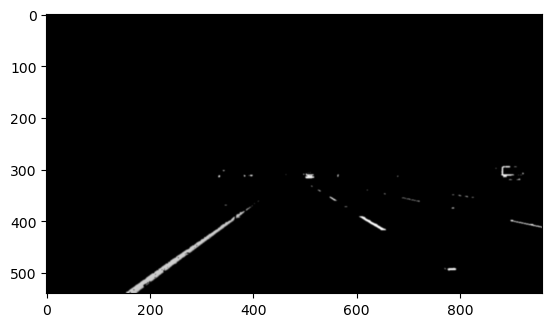

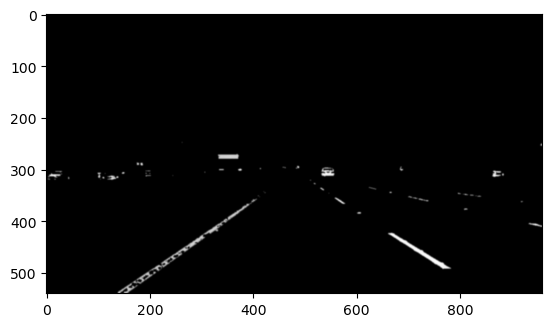

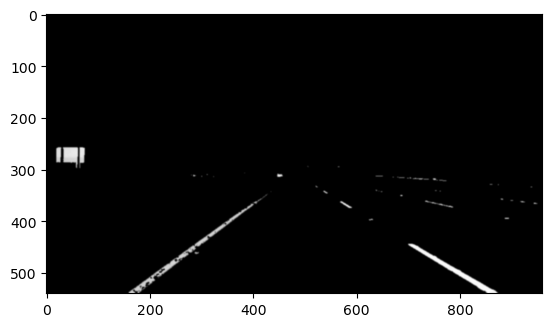

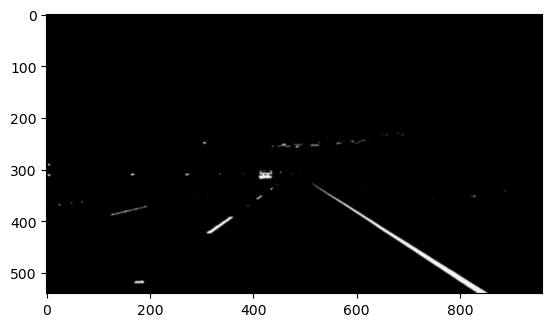

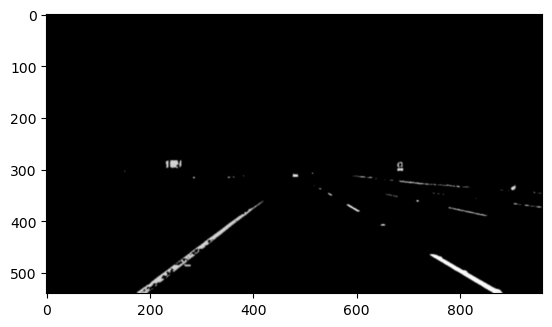

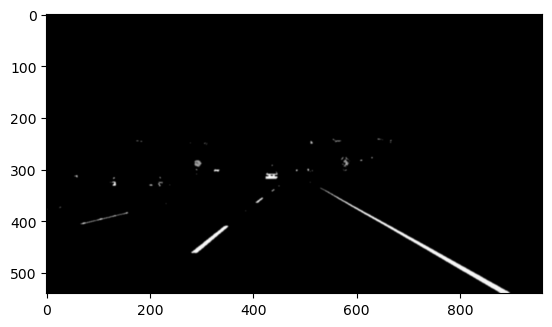

In [6]:
blurred = []  # a list that will contain the blurred images
# blurring the grayed image to remove uncessary edges
for grayed_image in grayed:
    blured_image = gaussian_blur(grayed_image, 5)
    blurred.append(blured_image)
    plt.figure()
    plt.imshow(blured_image, cmap='gray')

# Saving one of the images for the report
cv2.imwrite("test_images_output/image"+"3"+"blurred.png", cv2.cvtColor(blurred[3], cv2.COLOR_RGB2BGR))

True

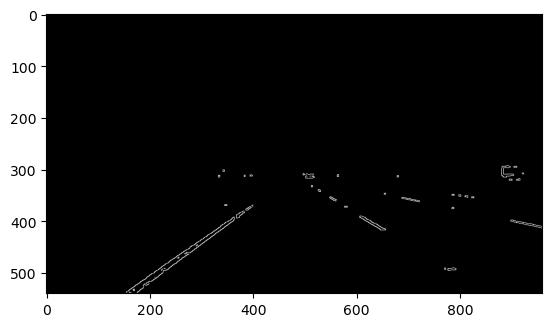

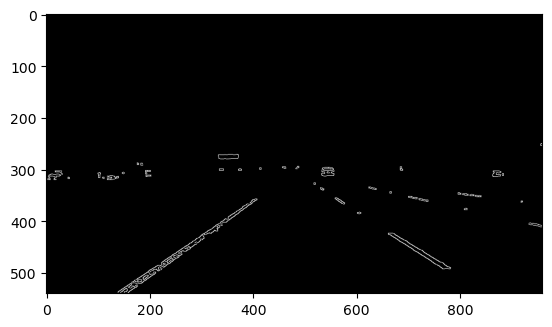

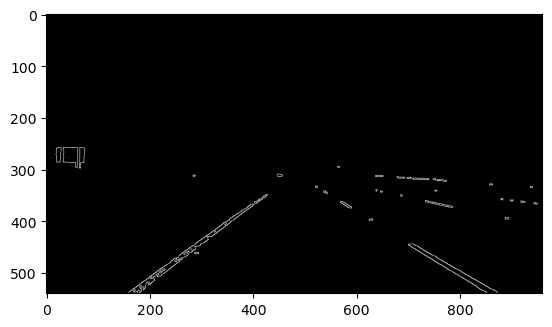

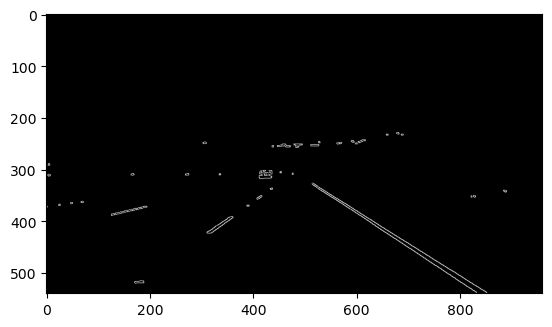

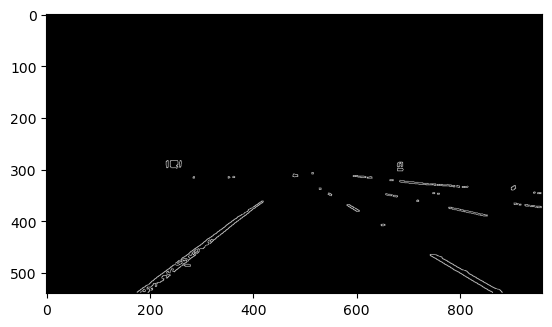

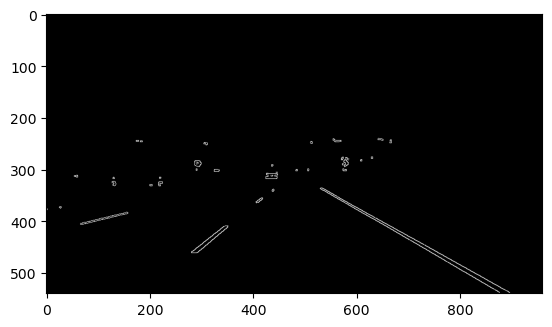

In [7]:
cannyed = []  # a list that will contain the images after the canny transoform
# detecting the edges on the images above and highligting them
for blured_image in blurred:
    cannyed_image = canny(blured_image, 25, 200)
    cannyed.append(cannyed_image)
    plt.figure()
    plt.imshow(cannyed_image, cmap='gray')
# Saving one of the images for the report    
cv2.imwrite("test_images_output/image"+"3"+"cannyed.png", cv2.cvtColor(cannyed[3], cv2.COLOR_RGB2BGR))

True

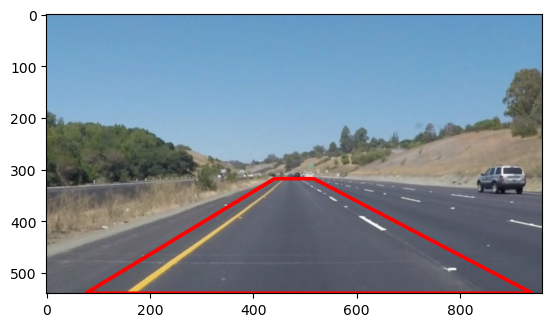

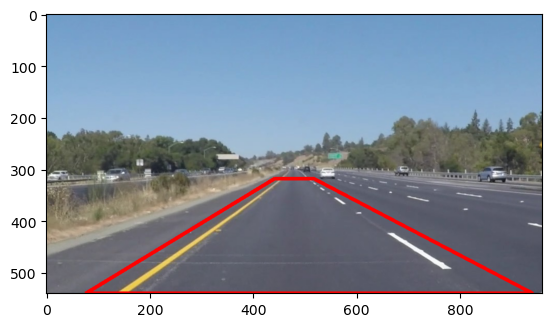

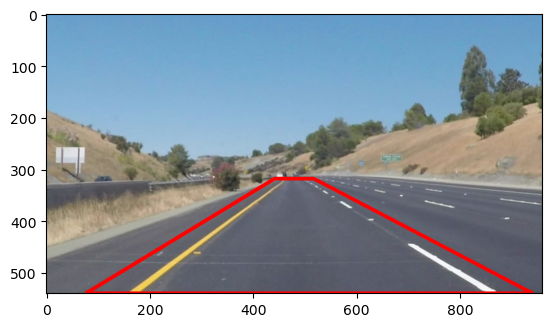

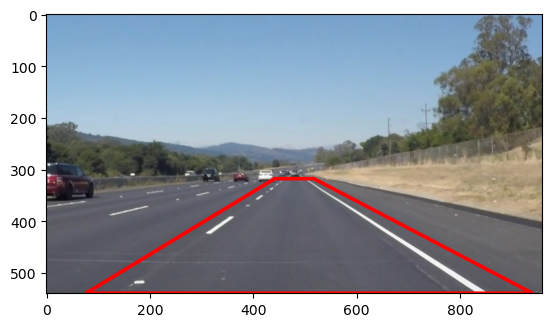

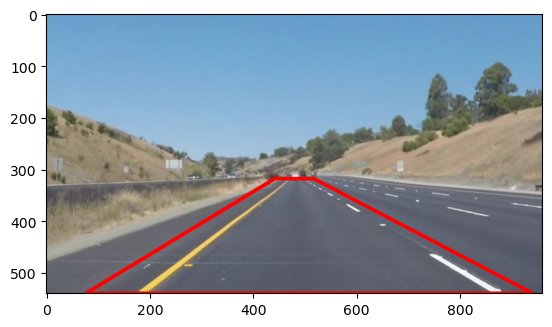

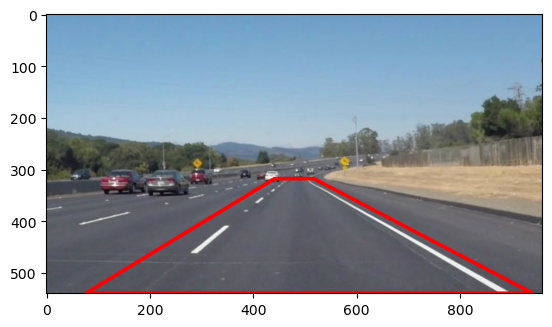

In [8]:
# the vertices that show the region of interest
vertices = np.array([[(round(0.08*x_size), y_size), (round(0.46*x_size), round(0.59*y_size)), (round(0.54*x_size), round(0.59*y_size)), (round(0.98*x_size), y_size)]])
highlighted = []
# showing the region of interest on the images, just for illustration purposes.
# Notice how the vertices were made a percentage of the height and width of the image, 
# so this is compatible with any size of the same height:width ratio.
for image in raw_images:
    # creating a copy of the image in order to edit it
    img = np.copy(image)
    highlighted_image = cv2.polylines(img, vertices, isClosed=True, color=(255, 0, 0), thickness=5)
    highlighted.append(highlighted_image)
    plt.figure()
    plt.imshow(highlighted_image)
# Saving one of the images for the report    
cv2.imwrite("test_images_output/image"+"3"+"highlighted.png", cv2.cvtColor(highlighted[3], cv2.COLOR_RGB2BGR))

True

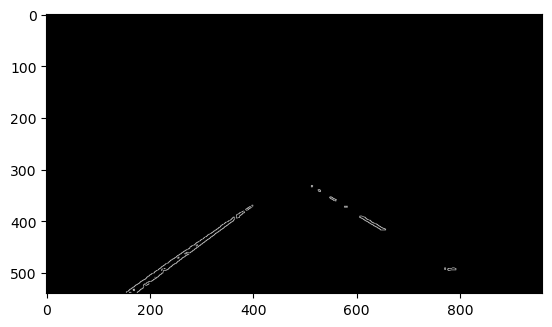

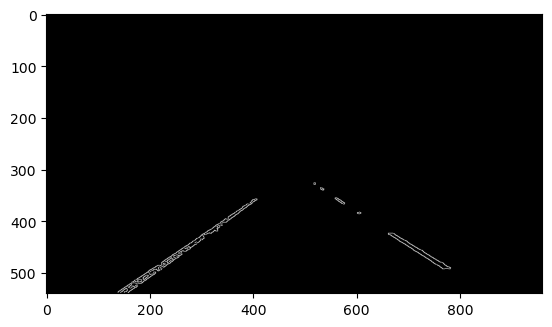

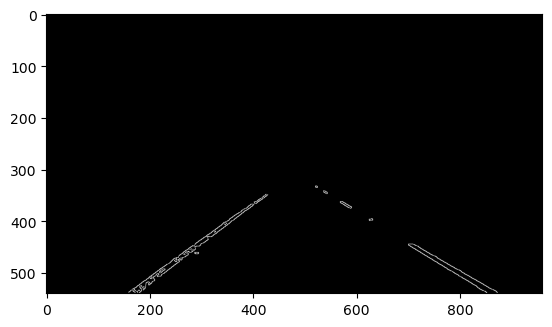

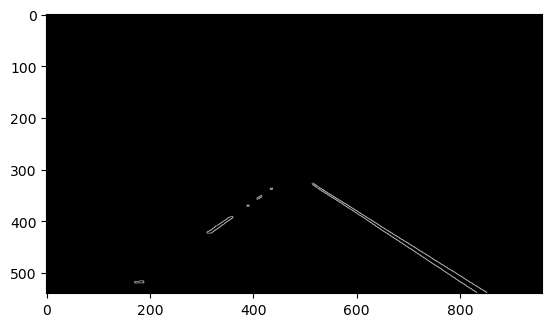

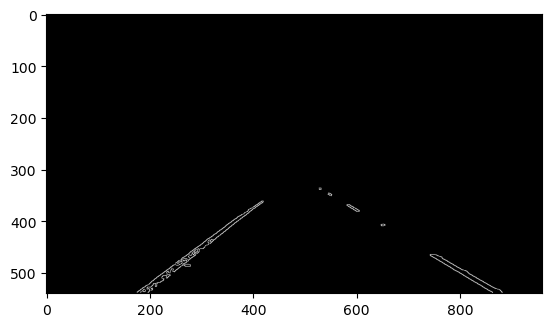

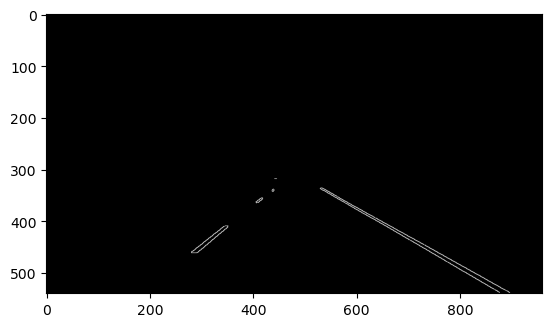

In [9]:
# Now the region of focus can be determined
focused = []
for image in cannyed:
    focused_image = region_of_interest(image, vertices)
    focused.append(focused_image)
    plt.figure()
    plt.imshow(focused_image, cmap='gray')
# Saving one of the images for the report
cv2.imwrite("test_images_output/image"+"3"+"focused.png", cv2.cvtColor(focused[3], cv2.COLOR_RGB2BGR))

True

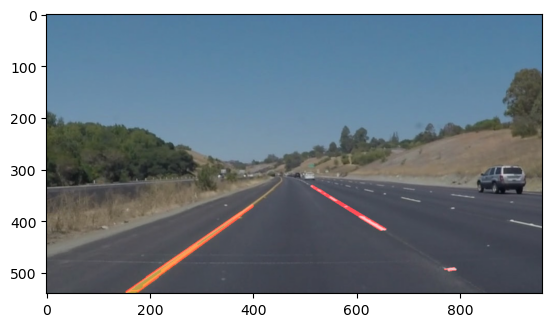

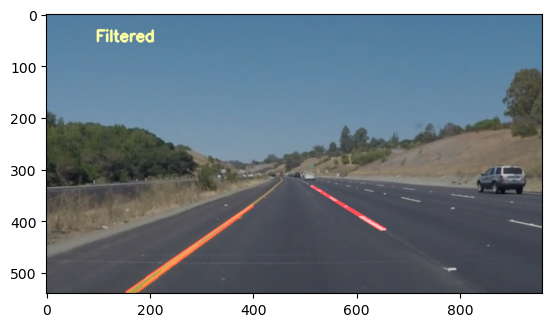

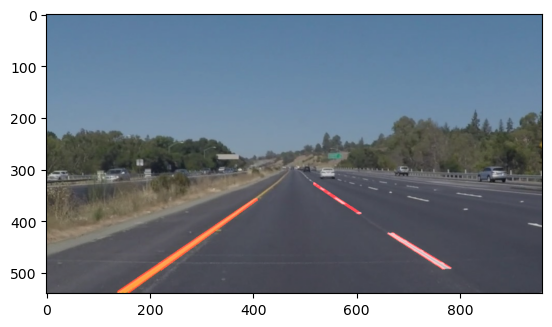

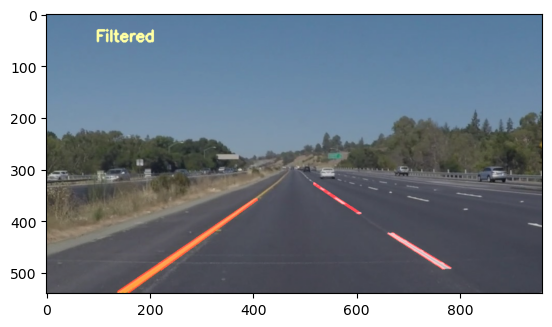

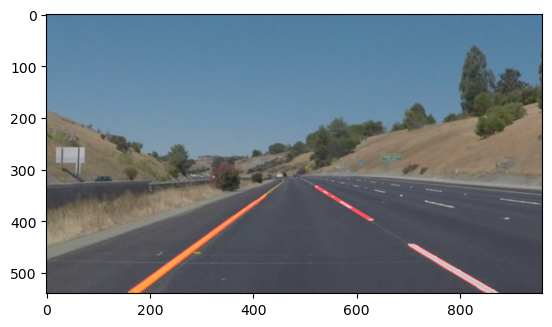

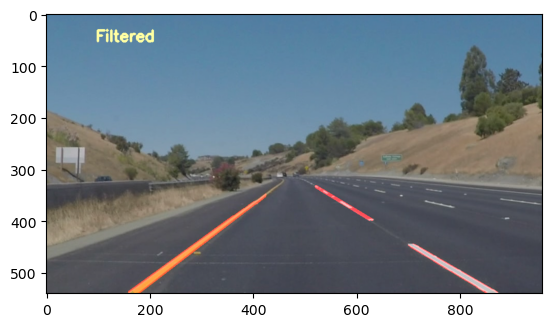

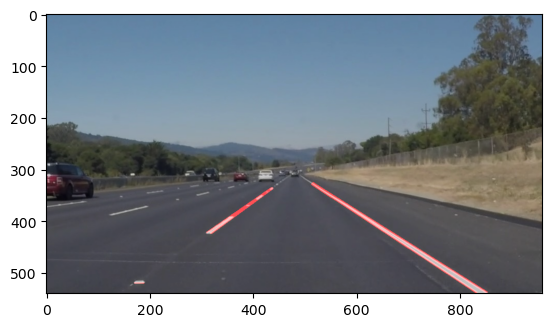

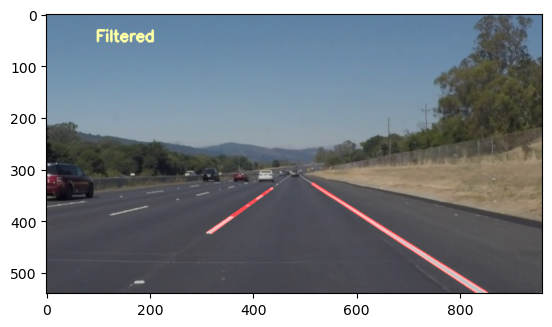

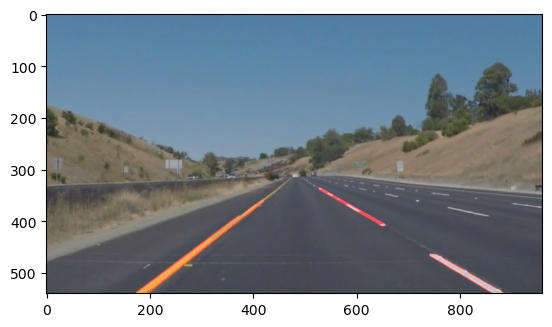

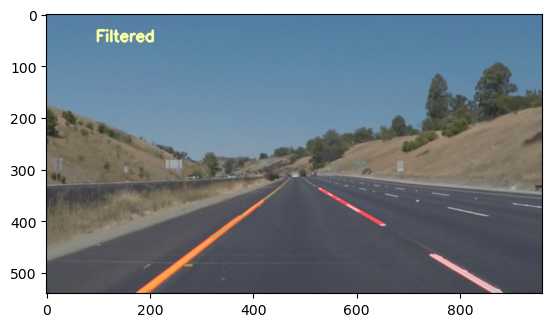

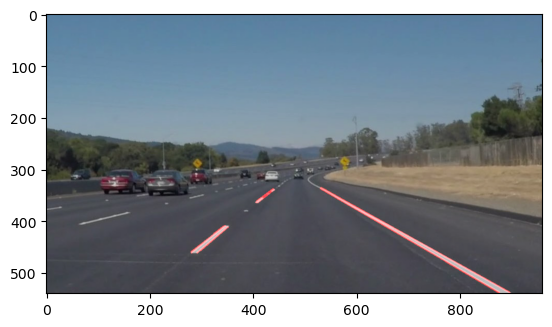

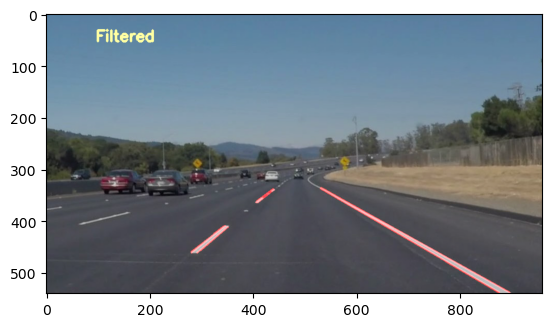

In [10]:
with_lines = []
# comparing the lines before and after filtering abnormal lines, just for illustration. Not part of the pipeline.
for i in range(len(focused)):
    # getting the image with lines and the lines themselves
    line_image, lines = hough_lines(focused[i], rho=1, theta=np.radians(0.5), threshold=15, min_line_len=15, max_line_gap=50)
    # removing lines with horizontal, vertical and other abnormal slopes
    filtered_lines = filter_lines(lines, threshold=3)
    # a black image to draw the filtered lines on
    filtered_lines_image = np.zeros_like(line_image)
    # drawing the filtered lines
    draw_lines(filtered_lines_image, filtered_lines)
    
    # writing "filtered", so it is easier to make comparisons
    cv2.putText(filtered_lines_image, "Filtered", (round(0.1*x_size), round(0.1*y_size)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)
    
    # combining the black images with lines with the raw color image, to highlight the lines on the road
    plt.figure()
    plt.imshow(weighted_img(line_image, raw_images[i]))
    
    image_with_lines = weighted_img(filtered_lines_image, raw_images[i])
    with_lines.append(image_with_lines)
    
    plt.figure()
    plt.imshow(image_with_lines)
# Saving one of the images for the report 
cv2.imwrite("test_images_output/image"+"3"+"with_lines.png", cv2.cvtColor(with_lines[3], cv2.COLOR_RGB2BGR))

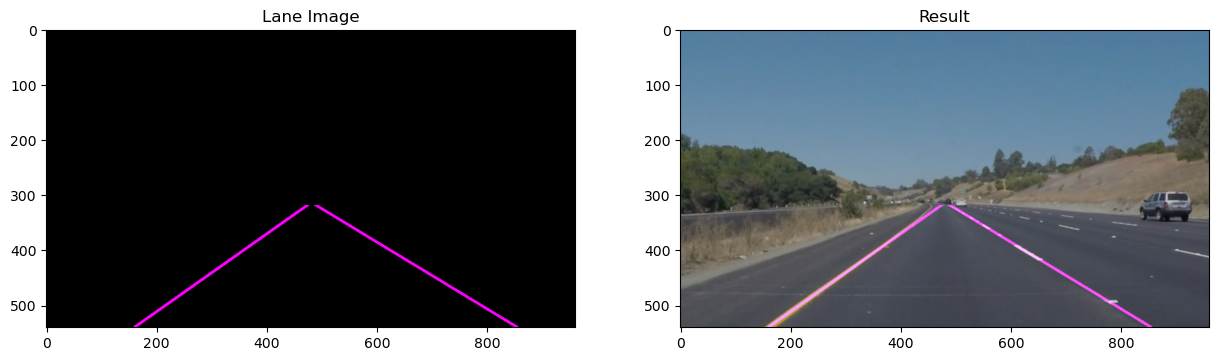

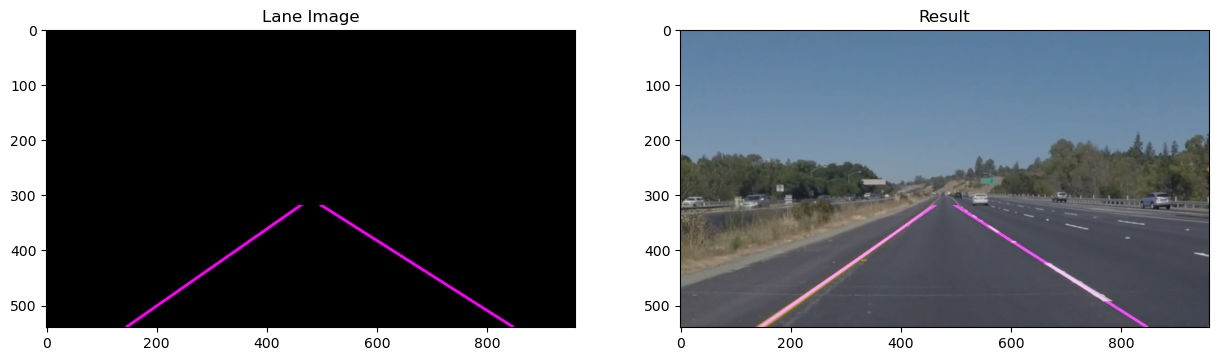

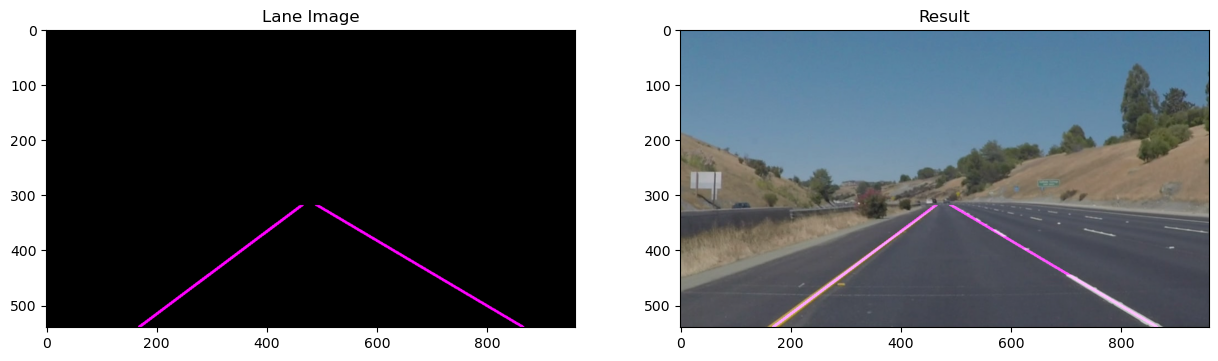

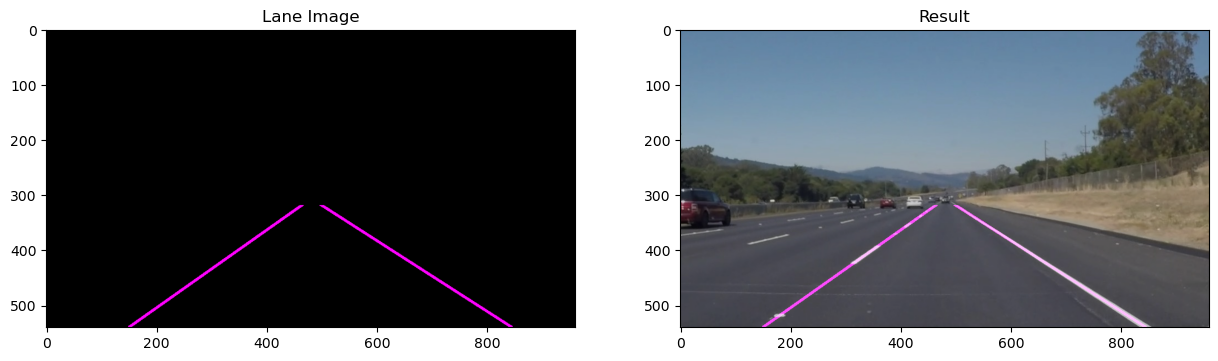

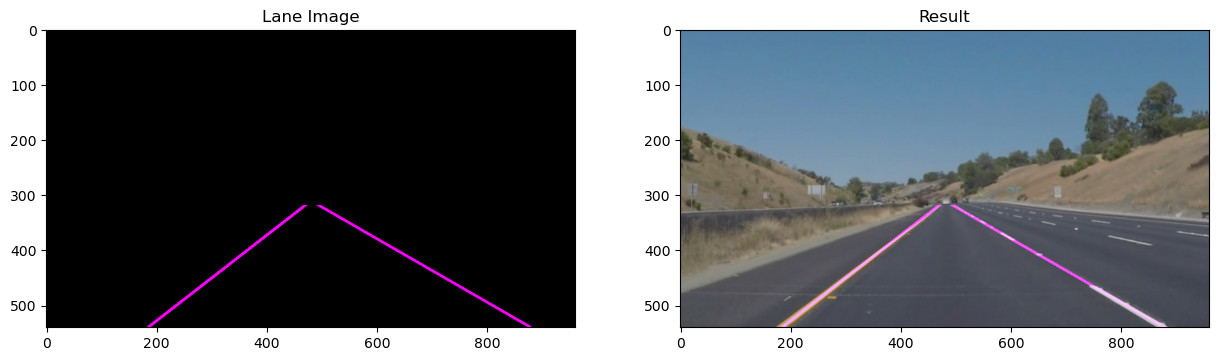

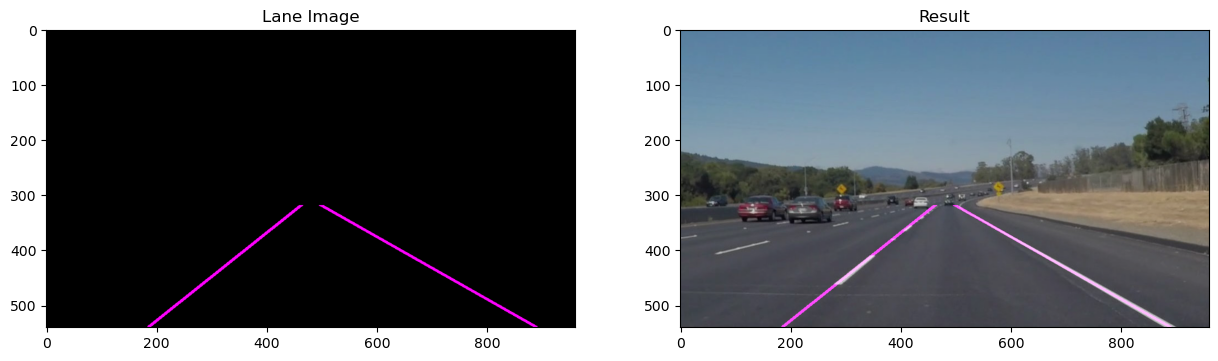

In [11]:
import matplotlib.pyplot as plt

i = 0  # a variable to keep track of the iterations
for image in focused:
    # getting the lines given by the hough transform
    lines = cv2.HoughLinesP(image, rho=1, theta=np.radians(0.5), threshold=15, minLineLength=15, maxLineGap=50)
    # drawing the lanes in the black image. Purple is used for better visibility of yellow lanes, when compared to red.
    lane_image = draw_lanes(image, vertices, lines, color=[255,0,255], thickness=4)
    
    # plotting the black image with lanes combined with the original image
    result = weighted_img(lane_image, raw_images[i])

    # Create a figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Display lane_image in the left column
    ax1.imshow(lane_image)
    ax1.set_title('Lane Image')

    # Display result in the right column
    ax2.imshow(result)
    ax2.set_title('Result')

    # saving the resulting image in "test_images_output"
    # Notice that the result needs to be converted to BGR
    cv2.imwrite("test_images_output/image"+str(i)+"final_result.png", cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    i += 1


Ground truth mask size: (540, 960)
Detected lane mask size: (540, 960)
MSE: 1.0084241282436948
Precision: 0.9705738106915155
Recall: 0.7128962536023055
F1 Score: 0.8220145379023883
Accuracy: 0.7128962536023055


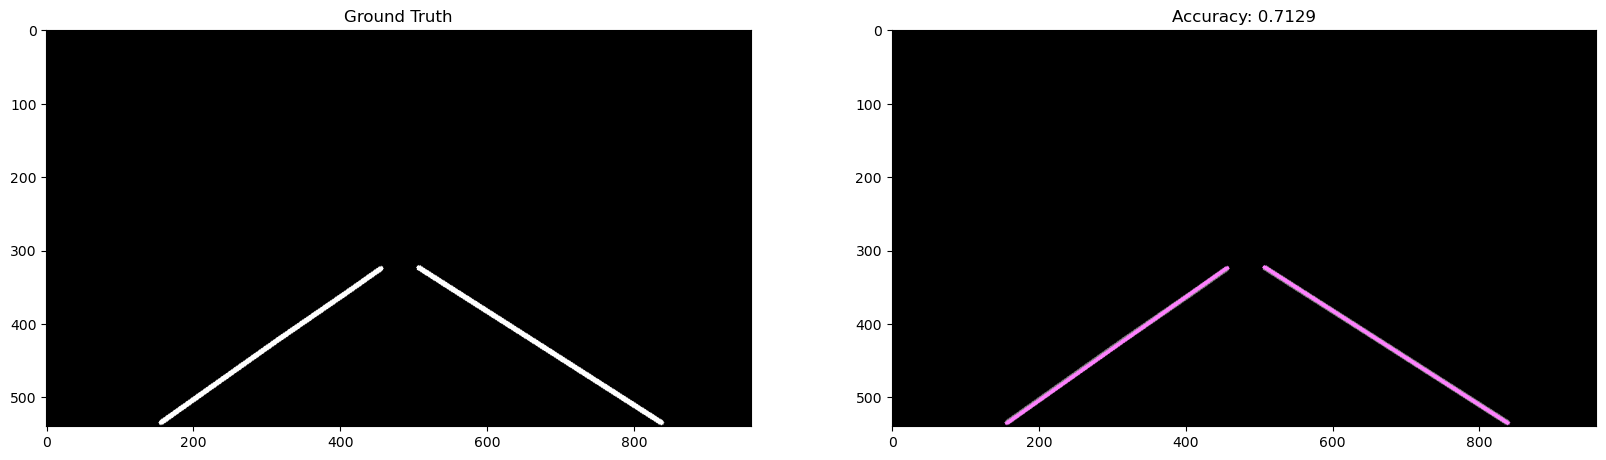

In [45]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Your existing lane_finding_pipeline function is here.
def process_image_evaluation(image):
    raw_images = image
    y_size, x_size, _ = image.shape
    new_image = color_focus(raw_images)
    grayed_image = grayscale(new_image)
    blured_image = gaussian_blur(grayed_image, 5)
    cannyed_image = canny(blured_image, 25, 200)
    vertices = np.array([[(round(0.08*x_size), y_size), (round(0.46*x_size), round(0.59*y_size)), (round(0.54*x_size), round(0.59*y_size)), (round(0.98*x_size), y_size)]])
    img = np.copy(raw_images)
    highlighted_image = cv2.polylines(img, vertices, isClosed=True, color=(255, 0, 0), thickness=5)
    focused_image = region_of_interest(cannyed_image, vertices)
    # getting the lines given by the hough transform
    lines = cv2.HoughLinesP(focused_image, rho=1, theta=np.radians(0.5), threshold=15, minLineLength=15, maxLineGap=50)
    # drawing the lanes in the black image. Purple is used for better visibility of yellow lanes, when compared to red.
    lane_image = draw_lanes(focused_image, vertices, lines, color=[255,0,255], thickness=4)     

    return lane_image

def create_ground_truth_mask(img_shape, left_lane_points, right_lane_points):
    ground_truth_mask = np.zeros((img_shape[0], img_shape[1]), dtype=np.uint8)
    cv2.polylines(ground_truth_mask, [np.array(left_lane_points, dtype=np.int32)], isClosed=False, color=255, thickness=5)
    cv2.polylines(ground_truth_mask, [np.array(right_lane_points, dtype=np.int32)], isClosed=False, color=255, thickness=5)
    
    return ground_truth_mask

def preprocess_masks(ground_truth_mask, detected_lane_mask):
    # Ensure both images have the same shape
    assert ground_truth_mask.shape == detected_lane_mask.shape, "Images must have the same shape."

    # Convert both images to grayscale if they are not already
    if len(ground_truth_mask.shape) == 3:
        ground_truth_mask = cv2.cvtColor(ground_truth_mask, cv2.COLOR_BGR2GRAY)
    if len(detected_lane_mask.shape) == 3:
        detected_lane_mask = cv2.cvtColor(detected_lane_mask, cv2.COLOR_BGR2GRAY)

    # Threshold the images to create binary masks
    _, ground_truth_mask = cv2.threshold(ground_truth_mask, 127, 255, cv2.THRESH_BINARY)
    _, detected_lane_mask = cv2.threshold(detected_lane_mask, 127, 255, cv2.THRESH_BINARY)

    return ground_truth_mask, detected_lane_mask


def calculate_accuracy(ground_truth_mask, detected_lane_mask, tolerance=5):
    ground_truth_mask, detected_lane_mask = preprocess_masks(ground_truth_mask, detected_lane_mask)
    
    # Calculate the difference between the ground truth and the detected lane mask
    diff = cv2.absdiff(ground_truth_mask, detected_lane_mask)

    # Count the number of pixels with a difference less than or equal to the tolerance
    #correct_pixels = np.sum(diff <= tolerance)
    correct_pixels_mask = np.logical_and(ground_truth_mask, detected_lane_mask)
    correct_pixels = np.sum(correct_pixels_mask)
    # Calculate the accuracy
    total_pixels = np.sum(ground_truth_mask > 0)
    accuracy = correct_pixels / total_pixels

    return accuracy, correct_pixels_mask

def calculate_precision_recall_f1(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1
def calculate_tp_fp_fn(ground_truth_mask, detected_lane_mask):
    ground_truth_mask, detected_lane_mask = preprocess_masks(ground_truth_mask, detected_lane_mask)
    tp = np.sum(np.logical_and(ground_truth_mask, detected_lane_mask))
    fp = np.sum(np.logical_and(np.logical_not(ground_truth_mask), detected_lane_mask))
    fn = np.sum(np.logical_and(ground_truth_mask, np.logical_not(detected_lane_mask)))

    return tp, fp, fn
def calculate_mse(ground_truth_mask, detected_lane_mask):
    ground_truth_mask, detected_lane_mask = preprocess_masks(ground_truth_mask, detected_lane_mask)
    # Find contours in ground truth and detected lane masks
    gt_contours, _ = cv2.findContours(ground_truth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_contours, _ = cv2.findContours(detected_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mse = 0
    n = len(gt_contours)
    for i in range(n):
        mse += cv2.matchShapes(gt_contours[i], detected_contours[i], cv2.CONTOURS_MATCH_I1, 0)
    mse /= n
    return mse


# Global variables
left_lane_points = []
right_lane_points = []
drawing = False
current_lane = "left"

# Mouse callback function
def draw_lane(event, x, y, flags, param):
    global drawing, left_lane_points, right_lane_points, current_lane

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        if current_lane == "left":
            left_lane_points.append((x, y))
        else:
            right_lane_points.append((x, y))
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            if current_lane == "left":
                left_lane_points.append((x, y))
            else:
                right_lane_points.append((x, y))
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        if current_lane == "left":
            left_lane_points.append((x, y))
        else:
            right_lane_points.append((x, y))
# Load your test image
img = cv2.imread('test_images/solidWhiteRight.jpg')
vertices = np.array([[(round(0.08*x_size), y_size), (round(0.46*x_size), round(0.59*y_size)), (round(0.54*x_size), round(0.59*y_size)), (round(0.98*x_size), y_size)]])
img = cv2.polylines(img, vertices, isClosed=True, color=(255, 0, 0), thickness=5)
# Create a window and set the mouse callback function
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw_lane)
##使用鼠标在图像上绘制左侧车道线。
##按 'r' 键，然后使用鼠标在图像上绘制右侧车道线。
##如果需要重新开始，按 'c' 键清除所有点并重新绘制。
##当您满意所绘制的车道线时，按 'q' 键退出循环。
while(1):
    img_copy = img.copy()
    cv2.polylines(img_copy, [np.array(left_lane_points, dtype=np.int32)], isClosed=False, color=(0, 0, 255), thickness=5)
    cv2.polylines(img_copy, [np.array(right_lane_points, dtype=np.int32)], isClosed=False, color=(0, 255, 0), thickness=5)
    cv2.imshow('image', img_copy)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        current_lane = "right"
    elif key == ord('c'):
        left_lane_points = []
        right_lane_points = []
        current_lane = "left"

cv2.destroyAllWindows()

# Run the lane detection algorithm
img_out = process_image_evaluation(mpimg.imread('test_images/solidWhiteRight.jpg'))

# Convert the detected lane lines image to a binary mask
detected_lane_mask = cv2.cvtColor(img_out, cv2.COLOR_RGB2GRAY)
_, detected_lane_mask = cv2.threshold(detected_lane_mask, 1, 255, cv2.THRESH_BINARY)

# Create the ground truth mask image
ground_truth_mask = create_ground_truth_mask(img.shape, left_lane_points, right_lane_points)

# Calculate the accuracy
accuracy , correct_pixels_mask = calculate_accuracy(ground_truth_mask, detected_lane_mask)
# Calculate TP, FP, and FN
tp, fp, fn = calculate_tp_fp_fn(ground_truth_mask, detected_lane_mask)

# Calculate Precision, Recall, and F1 Score
precision, recall, f1 = calculate_precision_recall_f1(tp, fp, fn)

# Calculate MSE
mse = calculate_mse(ground_truth_mask, detected_lane_mask)
print("Ground truth mask size:", ground_truth_mask.shape)
print("Detected lane mask size:", detected_lane_mask.shape)

print("MSE:", mse)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Show the ground truth and detected lane lines side by side for comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title('Ground Truth')
ax1.imshow(ground_truth_mask, cmap='gray')

ax2.set_title('Detected Lane Lines')
ax2.imshow(detected_lane_mask, cmap='gray')

# Convert the correct pixels mask to BGR format for display
correct_pixels_mask = np.stack((correct_pixels_mask.astype(np.uint8) * 255,) * 3, axis=-1)
correct_pixels_mask[:,:,1] = 0  # Set the green channel to 0 to show the correct pixels in green

# Convert the ground truth mask to BGR format for display
ground_truth_mask = np.stack((ground_truth_mask,) * 3, axis=-1)

# Display the image with the correct pixels highlighted in green
result = cv2.addWeighted(ground_truth_mask, 0.5, correct_pixels_mask, 0.5, 0)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title(f'Accuracy: {accuracy:.4f}')
plt.show()

## Test on Videos

In this section, the lanes will be drawn on videos.

In [13]:
def process_image(image):
    """This function takes an image and returns a copy of the images with the lanes drawn on it, by following the pipeline described above"""
    
    try:
        # get the shape of the image
        y_size, x_size, _ = image.shape
        
        # vertices defining the region of interest
        vertices = np.array([[(round(0.08*x_size), y_size), (round(0.46*x_size), round(0.59*y_size)), (round(0.54*x_size), round(0.59*y_size)), (round(0.98*x_size), y_size)]])
        # applying color detection, grayscaling, blurring, canny edge detection and region of interest to the image
        img = region_of_interest(canny(gaussian_blur(grayscale(color_focus(image)), 5), 50, 200), vertices)
        # getting the lines from a Hough transform line detection
        lines = cv2.HoughLinesP(img, rho=1, theta=np.radians(1), threshold=15, minLineLength=15, maxLineGap=50)
        # drawing the lanes on a black image
        lane_image = draw_lanes(image, vertices, lines, color=[255,0,255], thickness=4, filter_threshold=3)
        # combining the the black lane image with the orignal one to get the result
        result = weighted_img(lane_image, image)
        return result
    
    # if there's any error, return a black image
    except e:
        print(e)
        return np.zeros_like(image)

In [14]:
def addFrameN(clip):
    """
    A function to help with debbugging.
    It takes a video as input and returns a copy of the video with frame numbers written on it.
    """
    # getting each frame as an array in a numpy array
    frames = np.array(list(clip.iter_frames()))
    new_clip = np.zeros_like(frames)  # a placeholder for the returned video
    
    i = 0
    for frame in frames:
        cv2.putText(frame, str(i), (round(0.1*x_size), round(0.1*y_size)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        new_clip[i] = frame
        i += 1
    return ImageSequenceClip(list(new_clip), fps=clip.fps)

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# white_clip = addFrameN(white_clip)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 1.36 s, sys: 206 ms, total: 1.57 s
Wall time: 2.25 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
# yellow_clip = addFrameN(yellow_clip)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 4.36 s, sys: 564 ms, total: 4.92 s
Wall time: 6.45 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [19]:
def process_image1(image):
    """This function takes an image and returns a copy of the images with the lanes drawn on it, by following the pipeline described above"""
    
    try:
        # get the shape of the image
        y_size, x_size, _ = image.shape
        
        # vertices defining the region of interest
        vertices = np.array([[(round(0.08*x_size), y_size), (round(0.40*x_size), round(0.65*y_size)), (round(0.65*x_size), round(0.65*y_size)), (round(0.98*x_size), y_size)]])
        # applying color detection, grayscaling, blurring, canny edge detection and region of interest to the image
        img = region_of_interest(canny(gaussian_blur(grayscale(color_focus(image)), 5), 50, 200), vertices)
        # getting the lines from a Hough transform line detection
        lines = cv2.HoughLinesP(img, rho=1, theta=np.radians(1), threshold=15, minLineLength=15, maxLineGap=50)
        # drawing the lanes on a black image
        lane_image = draw_lanes(image, vertices, lines, color=[255,0,255], thickness=4, filter_threshold=3)
        # combining the the black lane image with the orignal one to get the result
        result = weighted_img(lane_image, image)
        return result
    
    # if there's any error, return a black image
    except e:
        print(e)
        return np.zeros_like(image)

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = addFrameN(clip3.fl_image(process_image1))
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 84.6 ms, sys: 99.2 ms, total: 184 ms
Wall time: 4.26 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))